<a href="https://colab.research.google.com/github/sarth-04/DDOS/blob/main/RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the dataset

In [58]:
################# Load the Dataset###################
#####################################################

import pandas as pd

# File paths: Modify the path as per your dataset location
file_path = '/content/balanced_ddos_benign_dataset.csv'

# Load the dataset using pandas
try:
    data = pd.read_csv(file_path)
    print("Dataset successfully loaded!")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check if the file path is correct.")

# Display basic information about the dataset
print("\nDataset Information:")
print(data.info())  # Shows column types and non-null counts

print("\nFirst 5 Rows of the Dataset:")
print(data.head())  # Displays the first 5 rows of the dataset to get an initial feel

# Check for missing values in the dataset
print("\nMissing Values in Each Column:")
print(data.isnull().sum())  # Summarizes missing values for each column

# Dataset size (rows and columns)
print("\nDataset Size (rows, columns):")
print(data.shape)


Dataset successfully loaded!

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 85 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Flow ID                       20000 non-null  object 
 1    Source IP                    20000 non-null  object 
 2    Source Port                  20000 non-null  int64  
 3    Destination IP               20000 non-null  object 
 4    Destination Port             20000 non-null  int64  
 5    Protocol                     20000 non-null  int64  
 6    Timestamp                    20000 non-null  object 
 7    Flow Duration                20000 non-null  int64  
 8    Total Fwd Packets            20000 non-null  int64  
 9    Total Backward Packets       20000 non-null  int64  
 10  Total Length of Fwd Packets   20000 non-null  int64  
 11   Total Length of Bwd Packets  20000 non-null  int64  
 12   Fwd Pack

#Import Libraries

In [59]:
################ Importing necessary libraries #######################
######################################################################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import gym
import tensorflow as tf
from tensorflow.keras import models, layers
import random
from collections import deque


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Load Data and Initial Preprocessing


In [60]:
################### Load and Preprocess the Data #######################
########################################################################

# Assuming 'data' is the DataFrame loaded from CSV
# data = pd.read_csv('path_to_your_dataset.csv')  # Uncomment to load your dataset

# Verify the initial columns
print("Initial Columns:", data.columns)

# Strip leading/trailing whitespaces from column names
data.columns = data.columns.str.strip()

# Drop irrelevant columns
columns_to_drop = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
data = data.drop(columns=columns_to_drop, inplace=False)
print(f"Dropped columns: {columns_to_drop}")

# Drop rows where 'Label' is missing
data = data.dropna(subset=['Label'])
print("Remaining Columns:", data.columns)


Initial Columns: Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet 

#Label Encoding

In [61]:
############# Initialize LabelEncoder and encode 'Label' column ######
######################################################################

le = LabelEncoder()
data['Label'] = le.fit_transform(data['Label'])

# Verify the encoding
print("Unique values in 'Label' after encoding:", data['Label'].unique())

# Print the label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:", label_mapping)


Unique values in 'Label' after encoding: [1 0]
Label Encoding Mapping: {'BENIGN': 0, 'DDoS': 1}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Handling Missing and Infinite Values

In [62]:
##### Identify numerical columns (excluding 'Label') #########
##############################################################

numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Label')  # Don't scale the 'Label' column

# Check for infinite values in numerical columns
infinite_cols = data[numerical_cols].columns[np.isinf(data[numerical_cols]).any()].tolist()
print(f"Columns with infinite values: {infinite_cols}")

# Replace infinite values with the maximum finite value of that column
for col in infinite_cols:
    max_value = data[np.isfinite(data[col])][col].max()
    data[col].replace([np.inf, -np.inf], max_value, inplace=True)
    print(f"Replaced infinite values in '{col}' with {max_value}")


Columns with infinite values: ['Flow Bytes/s', 'Flow Packets/s']
Replaced infinite values in 'Flow Bytes/s' with 1040000000.0
Replaced infinite values in 'Flow Packets/s' with 3000000.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-62-598fc64ee39c>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].replace([np.inf, -np.inf], max_value, inplace=True)


# Standard Scaling

In [63]:
################### Initialize the StandardScaler and scale the numerical columns ###########
#############################################################################################

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Verify scaling
print("\nFirst 5 rows of the scaled dataset:")
print(data.head())

# Confirm that the mean is approximately 0 and std is approximately 1 for each feature
scaled_summary = data[numerical_cols].describe().T[['mean', 'std']]
print("\nSummary statistics for scaled features (mean should be close to 0, std close to 1):")
print(scaled_summary)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



First 5 rows of the scaled dataset:
   Source Port  Destination Port  Protocol  Flow Duration  Total Fwd Packets  \
0     1.128060         -0.486219 -0.443583      -0.459949          -0.103988   
1     0.773765         -0.468866 -0.443583       3.111376           1.703983   
2    -1.137384         -0.486219 -0.443583      -0.329675          -0.103988   
3    -1.552884          0.593067 -0.443583      -0.191026          -0.210339   
4    -0.826652         -0.486219 -0.443583      -0.195190           0.002364   

   Total Backward Packets  Total Length of Fwd Packets  \
0                0.009977                    -0.317128   
1                0.929884                     5.184530   
2               -0.143341                    -0.321400   
3                0.009977                     0.094504   
4               -0.181670                    -0.315908   

   Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                     0.111829              -0.300225

#  Install Required Libraries

In [64]:
!pip install gym stable-baselines3 torch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Create a Custom Environment

In [65]:
import gym
from gym import spaces
import numpy as np

class DDoSEnv(gym.Env):
    def __init__(self, data, labels):
        super(DDoSEnv, self).__init__()

        # Define the state space (continuous features)
        self.observation_space = spaces.Box(
            low=np.min(data, axis=0), high=np.max(data, axis=0), dtype=np.float32
        )

        # Define the action space (BENIGN = 0, DDoS = 1)
        self.action_space = spaces.Discrete(2)

        # Store the dataset
        self.data = data
        self.labels = labels
        self.current_index = 0  # To track the current observation

    def reset(self):
        """Reset the environment to an initial state and return the first observation."""
        self.current_index = 0
        return self.data[self.current_index]

    def step(self, action):
        """Take an action and return (next_state, reward, done, info)."""
        # Get the true label for the current state
        true_label = self.labels[self.current_index]

        # Compute the reward: +1 for correct classification, -1 for incorrect
        reward = 1 if action == true_label else -1

        # Move to the next observation
        self.current_index += 1
        done = self.current_index >= len(self.data)  # Check if the episode is over

        # Return the next state, reward, done flag, and optional info
        if not done:
            next_state = self.data[self.current_index]
        else:
            next_state = None

        return next_state, reward, done, {}

    def render(self, mode="human"):
        """Optional: Print the current state (not required for RL training)."""
        pass


# Initialize the Environment

In [66]:
# Separate features and labels from the preprocessed dataset
X = data.drop(columns=["Label"]).values  # Features
y = data["Label"].map({0: 0, 1: 1}).values  # Target labels

# Initialize the custom environment
env = DDoSEnv(data=X, labels=y)

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


#Train the RL Model


In [67]:
!pip install 'shimmy>=2.0'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

# Wrap the environment (optional but helps for efficiency)
vec_env = make_vec_env(lambda: env, n_envs=1)

# Initialize the DQN agent
model = DQN("MlpPolicy", vec_env, verbose=1)


Using cpu device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


#Train the RL Agent

In [69]:
# Train the model for 10,000 timesteps
model.learn(total_timesteps=10000)

# Save the trained model
model.save("dqn_ddos_classifier")


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


#Evaluate the RL Model

In [70]:
# Load the trained model
model = DQN.load("dqn_ddos_classifier")

# Reset the environment
obs = env.reset()
total_reward = 0

# Simulate the agent in the environment
for _ in range(len(X)):  # Number of data points
    action, _states = model.predict(obs, deterministic=True)  # Predict the action
    obs, reward, done, info = env.step(action)  # Take the action
    total_reward += reward
    if done:
        break

print("Total Reward:", total_reward)


Total Reward: 19460


Model Accuracy: 98.65%


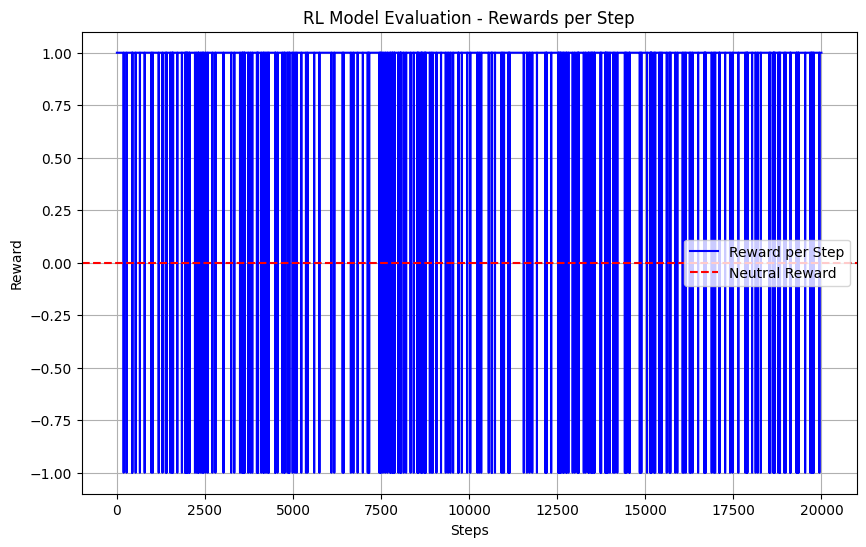

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the RL model and calculate accuracy
def evaluate_rl_model(env, model):
    obs = env.reset()  # Reset the environment
    correct_predictions = 0
    total_predictions = len(env.data)  # Total data points
    rewards = []  # Store rewards for plotting

    for _ in range(total_predictions):
        action, _ = model.predict(obs, deterministic=True)  # Predict the action
        obs, reward, done, info = env.step(action)  # Take the action
        rewards.append(reward)  # Append the reward

        # Check if the prediction matches the actual label
        if reward == 1:  # Reward is +1 for correct predictions
            correct_predictions += 1

        if done:
            break

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions * 100
    return accuracy, rewards

# Evaluate the model
accuracy, rewards = evaluate_rl_model(env, model)

# Print the accuracy
print(f"Model Accuracy: {accuracy:.2f}%")

# Plot the rewards for each step
plt.figure(figsize=(10, 6))
plt.plot(rewards, label="Reward per Step", color="blue")
plt.axhline(0, color="red", linestyle="--", label="Neutral Reward")
plt.title("RL Model Evaluation - Rewards per Step")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()
